In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn
!pip install scikit-learn statsmodels tensorflow
!pip install prophet yfinance
!pip install huggingface_hub

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ML models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prophet
from prophet import Prophet

# Evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def get_stock_data(symbol='AAPL', start_date='2015-01-01', end_date='2024-01-01'):
    """
    Get stock data with multiple fallback options
    """
    try:
        # Try the original symbol first
        data = yf.download(symbol, start=start_date, end=end_date, progress=False)
        if data.empty:
            raise ValueError(f"No data found for symbol: {symbol}")
        return data
    except Exception as e:
        print(f"Error with {symbol}: {e}")
        print("Trying alternative symbols...")

        # Try alternative symbols for Thai stocks or SET index
        alternatives = ['BBL.BK', 'PTT.BK', 'ADVANC.BK', '^SET', 'AAPL', 'GOOGL']

        for alt_symbol in alternatives:
            try:
                print(f"Trying {alt_symbol}...")
                data = yf.download(alt_symbol, start=start_date, end=end_date, progress=False)
                if not data.empty:
                    print(f"Successfully downloaded data for {alt_symbol}")
                    return data
            except:
                continue

        # If all else fails, create synthetic data for demonstration
        print("Creating synthetic stock data for demonstration...")
        return create_synthetic_data(start_date, end_date)

def create_synthetic_data(start_date, end_date):
    """
    Create synthetic stock price data for demonstration
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(dates)

    # Generate realistic synthetic data with trend and seasonality
    np.random.seed(42)
    trend = np.linspace(100, 200, n_days)
    seasonal = 10 * np.sin(2 * np.pi * np.arange(n_days) / 365)
    noise = np.random.normal(0, 5, n_days)

    prices = trend + seasonal + noise
    prices = np.maximum(prices, 10)  # Ensure positive prices

    data = pd.DataFrame({
        'Open': prices * 0.99,
        'High': prices * 1.02,
        'Low': prices * 0.98,
        'Close': prices,
        'Volume': np.random.randint(1000000, 10000000, n_days)
    }, index=dates)

    return data

# Get stock data
stock_data = get_stock_data('BBL.BK')  # Using Bangkok Bank as example
print(f"Data shape: {stock_data.shape}")
print(f"Date range: {stock_data.index.min()} to {stock_data.index.max()}")

Data shape: (2187, 5)
Date range: 2015-01-05 00:00:00 to 2023-12-28 00:00:00


In [7]:
def preprocess_data(data):
    """
    Preprocess stock price data
    """
    # Use closing prices
    if isinstance(data, pd.DataFrame):
        # Correctly extract the 'Close' price values as a 1D array
        prices = data[('Close', data['Close'].columns[0])].copy()
    else:
        prices = data.copy()

    # Handle missing values
    prices = prices.ffill().bfill()

    # Remove any remaining NaN values
    prices = prices.dropna()

    # Create DataFrame for Prophet
    df = pd.DataFrame({
        'ds': prices.index,
        'y': prices.values
    })

    return df, prices

# Preprocess data
df, prices = preprocess_data(stock_data)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Sample prices:\n{prices.head()}")

Data shape: (2187, 2)
Date range: 2015-01-05 00:00:00 to 2023-12-28 00:00:00
Sample prices:
Date
2015-01-05    124.926834
2015-01-06    124.598061
2015-01-07    125.913063
2015-01-08    126.241852
2015-01-09    124.926834
Name: (Close, BBL.BK), dtype: float64


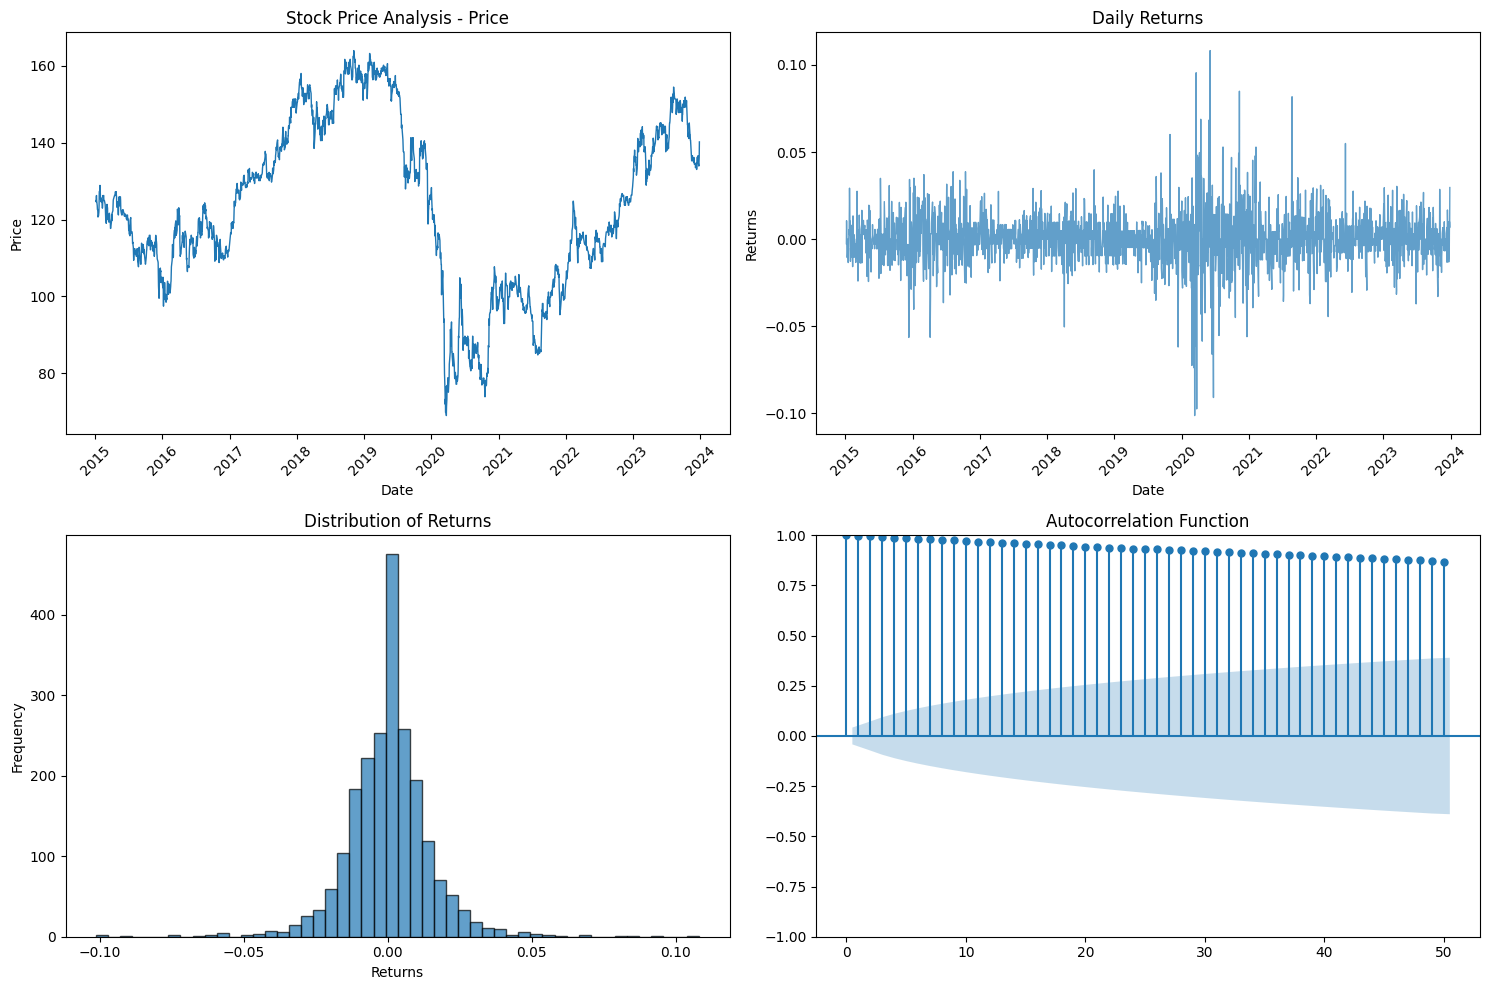

Basic Statistics:
Mean price: 123.55
Std price: 21.65
Min price: 69.06
Max price: 163.91
Total return: 12.20%


In [8]:
def plot_stock_analysis(prices, title="Stock Price Analysis"):
    """
    Comprehensive stock price analysis visualization
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Price time series
    axes[0, 0].plot(prices.index, prices.values, linewidth=1)
    axes[0, 0].set_title(f'{title} - Price')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Daily returns
    returns = prices.pct_change().dropna()
    axes[0, 1].plot(returns.index, returns.values, linewidth=1, alpha=0.7)
    axes[0, 1].set_title('Daily Returns')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Returns')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Histogram of returns
    axes[1, 0].hist(returns.dropna(), bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Distribution of Returns')
    axes[1, 0].set_xlabel('Returns')
    axes[1, 0].set_ylabel('Frequency')

    # Autocorrelation
    plot_acf(prices.dropna(), lags=50, ax=axes[1, 1], alpha=0.05)
    axes[1, 1].set_title('Autocorrelation Function')

    plt.tight_layout()
    plt.show()

    # Print basic statistics
    print("Basic Statistics:")
    print(f"Mean price: {prices.mean():.2f}")
    print(f"Std price: {prices.std():.2f}")
    print(f"Min price: {prices.min():.2f}")
    print(f"Max price: {prices.max():.2f}")
    print(f"Total return: {((prices.iloc[-1] / prices.iloc[0]) - 1) * 100:.2f}%")

plot_stock_analysis(prices)

In [9]:
def check_stationarity(timeseries):
    """
    Check stationarity using Augmented Dickey-Fuller test
    """
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    if result[1] <= 0.05:
        print("✅ Series is stationary")
        return True
    else:
        print("❌ Series is non-stationary - differencing required")
        return False

# Check stationarity
print("Original series:")
is_stationary = check_stationarity(prices)

# Check stationarity of returns if original is non-stationary
if not is_stationary:
    print("\nReturns series:")
    returns = prices.pct_change().dropna()
    check_stationarity(returns)

Original series:
ADF Statistic: -1.6748618922637941
p-value: 0.44410869556430993
Critical Values:
	1%: -3.4333532186762805
	5%: -2.862866720471125
	10%: -2.5674762791431696
❌ Series is non-stationary - differencing required

Returns series:
ADF Statistic: -18.301692892117448
p-value: 2.285871213216054e-30
Critical Values:
	1%: -3.4333532186762805
	5%: -2.862866720471125
	10%: -2.5674762791431696
✅ Series is stationary


In [10]:
def arima_forecast(train_data, test_data, order=(1,1,1)):
    """
    Implement ARIMA model for forecasting
    """
    try:
        # Fit ARIMA model
        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()

        # Forecast
        forecast = fitted_model.forecast(steps=len(test_data))

        return forecast, fitted_model
    except Exception as e:
        print(f"ARIMA error: {e}")
        # Return naive forecast as fallback
        last_value = train_data.iloc[-1]
        forecast = np.full(len(test_data), last_value)
        return forecast, None

def find_best_arima_order(data, max_p=3, max_d=2, max_q=3):
    """
    Find optimal ARIMA parameters using AIC
    """
    best_aic = np.inf
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted_model = model.fit()
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                    print(f"ARIMA({p},{d},{q}) - AIC: {fitted_model.aic:.2f}")
                except Exception as e:
                    continue

    print(f"✅ Best ARIMA order: {best_order} with AIC: {best_aic:.2f}")
    return best_order, best_aic

# Find best ARIMA parameters (use smaller range for stability)
best_order, best_aic = find_best_arima_order(prices, max_p=2, max_d=1, max_q=2)

ARIMA(0,0,0) - AIC: 19659.45
ARIMA(0,0,1) - AIC: 16832.71
ARIMA(0,0,2) - AIC: 14740.97
ARIMA(0,1,0) - AIC: 8369.02
ARIMA(0,1,1) - AIC: 8370.40
ARIMA(0,1,2) - AIC: 8364.98
ARIMA(1,0,0) - AIC: 8378.20
ARIMA(1,0,1) - AIC: 8379.39
ARIMA(1,0,2) - AIC: 8374.41
ARIMA(1,1,0) - AIC: 8370.48
ARIMA(1,1,1) - AIC: 8366.32
ARIMA(1,1,2) - AIC: 8366.89
ARIMA(2,0,0) - AIC: 8379.56
ARIMA(2,0,1) - AIC: 8375.28
ARIMA(2,0,2) - AIC: 8376.36
ARIMA(2,1,0) - AIC: 8364.77
ARIMA(2,1,1) - AIC: 8366.76
ARIMA(2,1,2) - AIC: 8366.10
✅ Best ARIMA order: (2, 1, 0) with AIC: 8364.77


In [11]:
def create_lstm_model(input_shape, units=50):
    """
    Create LSTM model architecture
    """
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def prepare_lstm_data(data, lookback=30):
    """
    Prepare data for LSTM model
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    return X, y, scaler

def lstm_forecast(train_data, test_data, lookback=30, epochs=20, batch_size=16):
    """
    Implement LSTM model for forecasting
    """
    try:
        # Prepare data
        X_train, y_train, scaler = prepare_lstm_data(train_data, lookback)

        # Create and train model
        model = create_lstm_model((X_train.shape[1], 1), units=50)

        # Use smaller epochs for faster training
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_split=0.1
        )

        # Prepare for forecasting
        forecasts = []
        current_batch = X_train[-1:].copy()

        for i in range(len(test_data)):
            current_pred = model.predict(current_batch, verbose=0)[0]
            forecasts.append(current_pred[0])

            # Update batch
            current_batch = np.roll(current_batch, -1)
            current_batch[0, -1, 0] = current_pred[0]

        # Inverse transform
        forecasts = np.array(forecasts).reshape(-1, 1)
        forecasts = scaler.inverse_transform(forecasts)

        return forecasts.flatten(), model

    except Exception as e:
        print(f"LSTM error: {e}")
        # Return naive forecast
        last_value = train_data.iloc[-1]
        forecast = np.full(len(test_data), last_value)
        return forecast, None

In [12]:
def prophet_forecast(train_df, test_periods):
    """
    Implement Facebook Prophet model for forecasting
    """
    try:
        # Create and fit Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )

        model.fit(train_df)

        # Create future dataframe
        future = model.make_future_dataframe(periods=test_periods, freq='D', include_history=False)

        # Forecast
        forecast = model.predict(future)

        return forecast, model
    except Exception as e:
        print(f"Prophet error: {e}")
        # Return naive forecast
        last_value = train_df['y'].iloc[-1]
        forecast_df = pd.DataFrame({
            'ds': pd.date_range(start=train_df['ds'].iloc[-1], periods=test_periods+1, freq='D')[1:],
            'yhat': np.full(test_periods, last_value)
        })
        return forecast_df, None

In [13]:
def rolling_window_evaluation(data, model_type='arima', window_size=180, test_size=30, **kwargs):
    """
    Perform rolling window evaluation
    """
    forecasts = []
    actuals = []

    # Use smaller window for faster computation
    n_windows = min(5, (len(data) - window_size - test_size) // test_size)

    print(f"Evaluating {model_type} with {n_windows} windows...")

    for i in range(0, n_windows * test_size, test_size):
        start_idx = i
        end_idx = i + window_size + test_size

        if end_idx > len(data):
            break

        train_data = data.iloc[start_idx:start_idx + window_size]
        test_data = data.iloc[start_idx + window_size:end_idx]

        if model_type == 'arima':
            forecast, _ = arima_forecast(train_data, test_data, **kwargs)
        elif model_type == 'lstm':
            forecast, _ = lstm_forecast(train_data, test_data, **kwargs)
        elif model_type == 'prophet':
            train_df = pd.DataFrame({'ds': train_data.index, 'y': train_data.values})
            forecast_df, _ = prophet_forecast(train_df, len(test_data))
            forecast = forecast_df['yhat'].values

        forecasts.extend(forecast)
        actuals.extend(test_data.values)

    return np.array(forecasts), np.array(actuals)

def calculate_metrics(actual, predicted):
    """
    Calculate evaluation metrics
    """
    # Handle division by zero in MAPE
    mask = actual != 0
    actual = actual[mask]
    predicted = predicted[mask]

    if len(actual) == 0:
        return {'RMSE': np.inf, 'MAE': np.inf, 'MAPE': np.inf, 'MSE': np.inf}

    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)

    try:
        mape = mean_absolute_percentage_error(actual, predicted)
    except:
        mape = np.inf

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MSE': mse
    }

In [14]:
def compare_models(data):
    """
    Compare performance of all models
    """
    results = {}

    # ARIMA evaluation
    print("🔍 Evaluating ARIMA model...")
    arima_forecasts, arima_actuals = rolling_window_evaluation(
        data, model_type='arima', order=(1,1,1)  # Using simple order for stability
    )
    results['ARIMA'] = calculate_metrics(arima_actuals, arima_forecasts)

    # LSTM evaluation
    print("🔍 Evaluating LSTM model...")
    lstm_forecasts, lstm_actuals = rolling_window_evaluation(
        data, model_type='lstm', lookback=30, epochs=10
    )
    results['LSTM'] = calculate_metrics(lstm_actuals, lstm_forecasts)

    # Prophet evaluation
    print("🔍 Evaluating Prophet model...")
    prophet_forecasts, prophet_actuals = rolling_window_evaluation(
        data, model_type='prophet'
    )
    results['Prophet'] = calculate_metrics(prophet_actuals, prophet_forecasts)

    # Naive model (persistence) as baseline
    print("🔍 Evaluating Naive model (baseline)...")
    naive_forecasts = np.roll(arima_actuals, 1)
    naive_forecasts[0] = arima_actuals[0]
    results['Naive'] = calculate_metrics(arima_actuals, naive_forecasts)

    return results, (arima_forecasts, lstm_forecasts, prophet_forecasts, naive_forecasts, arima_actuals)

# Compare all models
performance_results, all_forecasts = compare_models(prices)
arima_forecasts, lstm_forecasts, prophet_forecasts, naive_forecasts, actuals = all_forecasts

🔍 Evaluating ARIMA model...
Evaluating arima with 5 windows...
🔍 Evaluating LSTM model...
Evaluating lstm with 5 windows...
🔍 Evaluating Prophet model...
Evaluating prophet with 5 windows...


DEBUG:cmdstanpy:input tempfile: /tmp/tmphba_fawk/uv_0920f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphba_fawk/rbt6c0da.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70208', 'data', 'file=/tmp/tmphba_fawk/uv_0920f.json', 'init=/tmp/tmphba_fawk/rbt6c0da.json', 'output', 'file=/tmp/tmphba_fawk/prophet_modelooie8wwl/prophet_model-20251002184250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmphba_fawk/4mhc61_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphba_fawk/_l9ygdq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

🔍 Evaluating Naive model (baseline)...


In [15]:
def create_performance_table(results):
    """
    Create performance comparison table
    """
    comparison_df = pd.DataFrame(results).T
    comparison_df = comparison_df.round(4)

    # Highlight best model for each metric
    styled_df = comparison_df.style.highlight_min(subset=['RMSE', 'MAE', 'MAPE', 'MSE'], color='lightgreen')

    return comparison_df, styled_df

# Create performance table
performance_table, styled_table = create_performance_table(performance_results)
print("📊 Performance Comparison:")
print(performance_table)

# Display styled table if in notebook environment
try:
    display(styled_table)
except:
    pass

📊 Performance Comparison:
            RMSE      MAE     MAPE        MSE
ARIMA     6.6468   4.9774   4.4575    44.1802
LSTM      6.4420   5.2999   4.8176    41.4990
Prophet  58.5214  34.8851  32.8064  3424.7571
Naive     1.7710   1.3556   1.2362     3.1365


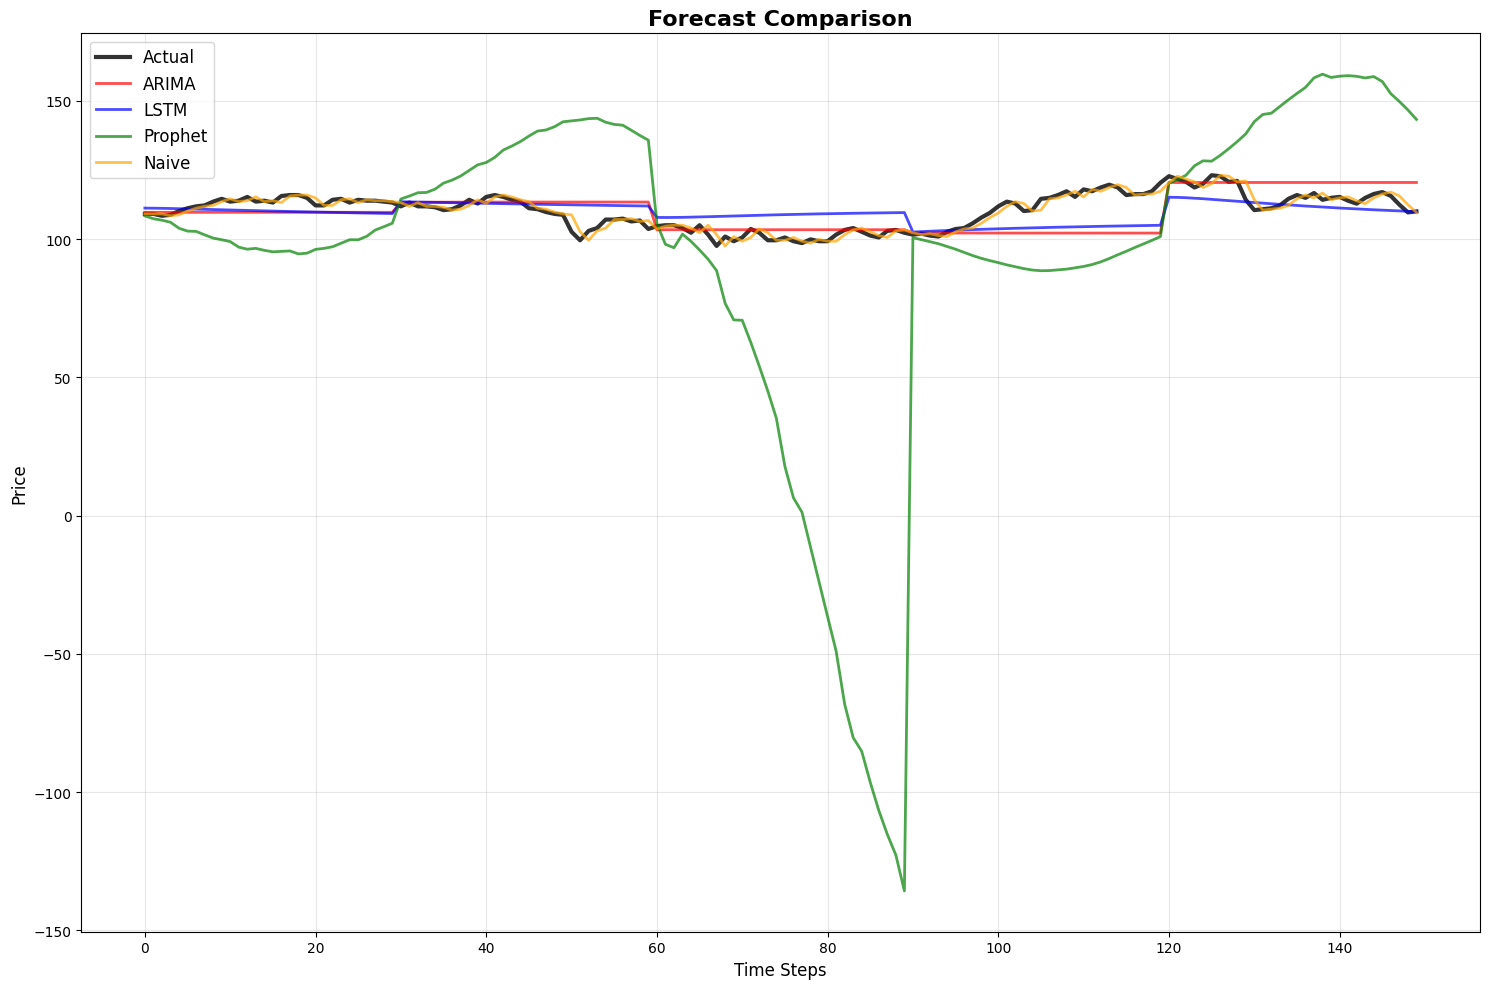

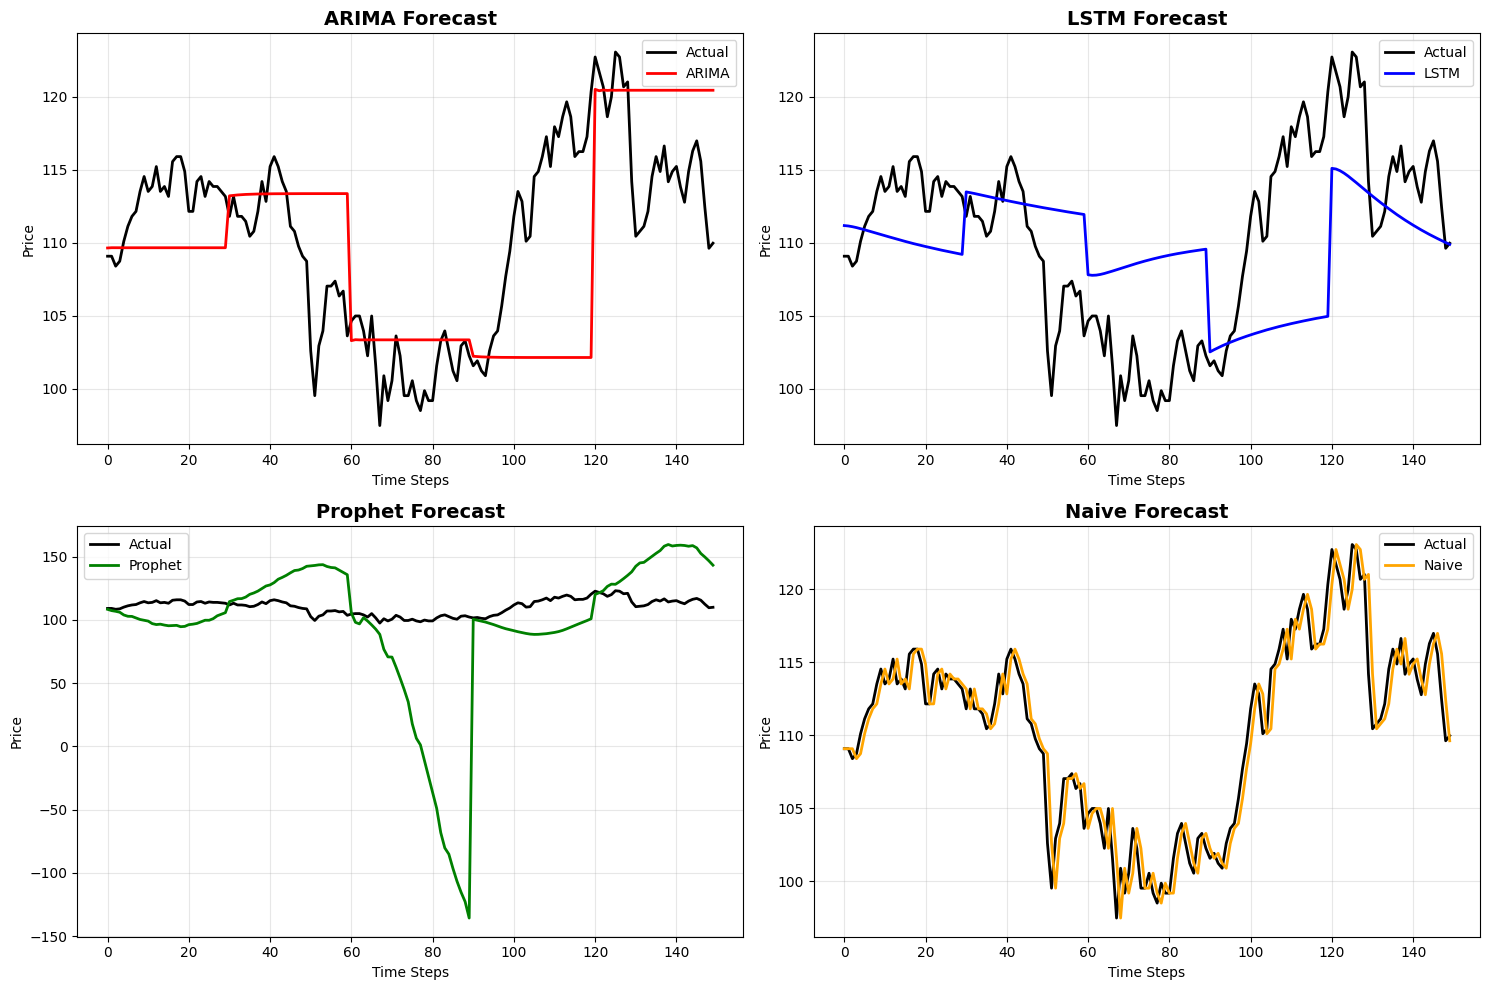

In [16]:
def plot_forecast_comparison(actual, forecasts_dict, title="Forecast Comparison"):
    """
    Plot comparison of different model forecasts
    """
    plt.figure(figsize=(15, 10))

    # Plot actual values
    plt.plot(actual, label='Actual', linewidth=3, color='black', alpha=0.8)

    # Plot forecasts
    colors = ['red', 'blue', 'green', 'orange']
    for i, (model_name, forecast) in enumerate(forecasts_dict.items()):
        plt.plot(forecast, label=model_name, color=colors[i], alpha=0.7, linewidth=2)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot results
forecasts_dict = {
    'ARIMA': arima_forecasts,
    'LSTM': lstm_forecasts,
    'Prophet': prophet_forecasts,
    'Naive': naive_forecasts
}
plot_forecast_comparison(actuals, forecasts_dict)

# Plot individual model performance
def plot_individual_forecasts(actual, forecasts_dict):
    """
    Plot individual model forecasts in subplots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, (model_name, forecast) in enumerate(forecasts_dict.items()):
        if i < len(axes):
            axes[i].plot(actual, label='Actual', color='black', linewidth=2)
            axes[i].plot(forecast, label=model_name, color=['red', 'blue', 'green', 'orange'][i], linewidth=2)
            axes[i].set_title(f'{model_name} Forecast', fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Time Steps')
            axes[i].set_ylabel('Price')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_individual_forecasts(actuals, forecasts_dict)